In [ ]:
import os
import cv2
from glob import glob
from tqdm import tqdm
from pathlib import Path
from zipfile import ZipFile
from natsort import natsorted
from huggingface_hub import snapshot_download
from Lib.Utils import create_dir, create_dataset, show_image, get_file_name, preprocess_img, generate_line_info, generate_line_image, save_line_transcription

In [ ]:
dataset_id = "Eric-23xd/Namgyal-OCR-Annotations"
annotations_path = "Data/Namgyal/Annotations"

create_dir(annotations_path)

data_dir = snapshot_download(repo_id=dataset_id, repo_type="dataset", cache_dir="Data")
print(data_dir)

zip_file = f"{data_dir}/data.zip"

if os.path.isfile(zip_file):
    try:
        with ZipFile(zip_file, "r") as zipFile:
            zipFile.extractall(path=annotations_path)

    except FileExistsError as e:
            print(e)

In [3]:
dataset_path = "Data/Namgyal/Dataset"
dataset_img_out = os.path.join(dataset_path, "lines")
dataset_transcriptions_out = os.path.join(dataset_path, "transcriptions")


create_dir(dataset_img_out)
create_dir(dataset_transcriptions_out)

#### Create Dataset from a Volume

In [ ]:
vol_dir = "Data/Namgyal/Annotations/W2KG229028-v3"
images = natsorted(glob(f"{vol_dir}/*.jpg"))
xml_files = natsorted(glob(f"{vol_dir}/page/*.xml"))

print(f"{vol_dir} => Images: {len(images)}, XML-Annotations: {len(xml_files)}")

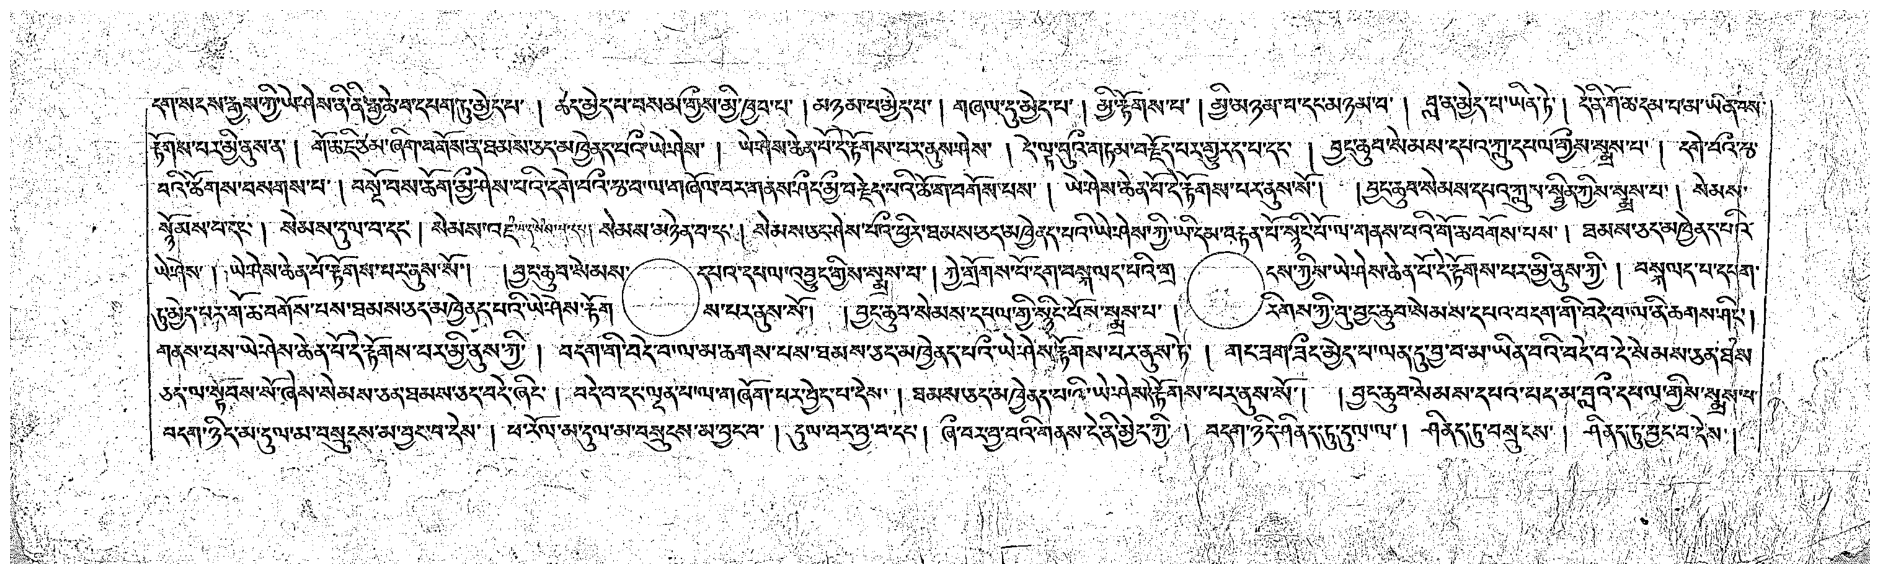

In [5]:
# process a single sample
sample_idx = 2
image_path = images[sample_idx]
image_name = get_file_name(image_path)
image = cv2.imread(images[sample_idx])
image = preprocess_img(image)
line_info = generate_line_info(xml_files[sample_idx])

show_image(image)

In [7]:
for xml_info in line_info:
        line_img = generate_line_image(image, xml_info.points, kernel_iterations=6)
        save_line_transcription(image_name, line_img, xml_info.id, xml_info.label, dataset_img_out, dataset_transcriptions_out)

#### Run dataset generation on all volumes

In [ ]:
## run on all volumes
for volume_dir in Path(annotations_path).iterdir():
    images = natsorted(glob(f"{volume_dir}/*.jpg"))
    xml_files = natsorted(glob(f"{volume_dir}/page/*.xml"))

    print(f"{volume_dir} => Images: {len(images)}, XML-Annotations: {len(xml_files)}")

    for image, annotation in tqdm(zip(images, xml_files), total=len(xml_files)):
        create_dataset(image, annotation, dataset_img_out, dataset_transcriptions_out)